In [1]:
import re
import sys
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multcomp
import matplotlib.pyplot as plt


from importlib import reload
import utils # in this directory

%matplotlib inline

In [ ]:
reload(utils) # in case changes were made to utils 

In [2]:
pit_mutations = pd.read_csv(utils.pit_mutations_path)
submissions = utils.getsubmissions(webcat_path=utils.webcat_path, users=pit_mutations.userName.unique(),
                                   assignments=['Project 2'])
mutators = utils.get_mutator_specific_data(pit_mutations=pit_mutations, submissions=submissions)
coverage = utils.all_mutator_data(mutators, 'cov')
agg_mutators = mutators.groupby('mutator').agg(['mean', 'std'])
joined = utils.get_main_subset_data(mutators, submissions=submissions)
del pit_mutations # no need to hold this in memory anymore 

In [12]:
def forward_selection(data, response):
    """Linear model designed by forward selection.
    Credit: https://planspace.org/20150423-forward_selection_with_statsmodels/
    
    Args:
        data (pd.DataFrame): All possible predictors and response
        response (str): Name of response column in `data`
        candidates (list): Candidate features

    Returns:
        model: an "optimal" fitted statsmodels linear model
               with an intercept
               selected by forward selection
               evaluated by adjusted R-squared
    """
    # add features in order of the specified sort_criteria
    candidates = list(data.columns)
    candidates.remove(response)
    remaining = candidates.copy() # keep candidates intact to measure savings
    selected = []
    maxint = sys.maxsize
    current_score, best_new_score = maxint, maxint
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            features = selected + [candidate]
            formula = '{} ~ {} + 1'.format(response, ' + '.join(features))
            
            aic = smf.ols(formula, data).fit().bic
            scores_with_candidates.append((aic, candidate))
            
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates[0]
        if current_score > best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score

    formula = '{} ~ {} + 1'.format(response, ' + '.join(selected))
    print('Selected {} / {} mutators'.format(len(selected), len(candidates)))
    
    selected_num = utils.get_data_for_subset(mutators, submissions=submissions, subset=selected)['num'].sum()
    original_num = utils.get_data_for_subset(mutators, submissions=submissions, subset=candidates)['num'].sum()
    print('{:.2%} of initial mutants'.format(selected_num / original_num))
    
    model = smf.ols(formula, data).fit()
    return model, selected

In [13]:
depvar = 'full_cov'
response = joined[depvar]
d = coverage[utils.pit_deletion] \
        .merge(response, right_index=True, left_index=True) \
        .fillna(0)
model, subset = forward_selection(d, depvar)
print('{:.2f}'.format(model.rsquared_adj), subset)

Selected 3 / 8 mutators
77.34% of initial mutants
0.95 ['RemoveConditional', 'NonVoidMethodCall', 'BooleanTrueReturnVals']


In [10]:
# Display summary infromation about arbitrary subsets
def incsubset_info(subset, name, depvar, runningtime_path, outfile=None):
    model = smf.ols('{} ~ {} + 1'.format(depvar, ' + '.join(subset)), data=d).fit()
    df = utils.get_data_for_subset(mutators, subset=subset, submissions=submissions)
    df['runningtime'] = utils.get_running_time(resultfile=runningtime_path)
    df['mpl'] = df['mpl'] * 1000
    df = df.merge(right=joined['full_cov'], right_index=True, left_index=True)
    print('Subset = ', subset)
    mpl_saving_del = (df['mpl'] / (joined['deletion_mpl'] * 1000)).mean()
    rt_saving_del = (df['runningtime'] / (joined['deletion_runningtime'])).mean()
    mpl_saving_full = (df['mpl'] / (joined['full_mpl'] * 1000)).mean()
    rt_saving_full = (df['runningtime'] / (joined['full_runningtime'])).mean()
    print('Running time = {:.2f}'.format(df['runningtime'].mean()))
    print('\t{:.2%} of del, {:.2%} of full'.format(rt_saving_del, rt_saving_full))
    print('MPL time = {:.2f}'.format(df['mpl'].mean()))
    print('\t{:.2%} of del, {:.2%} of full'.format(mpl_saving_del, mpl_saving_full))

    ax = sns.regplot(x='cov', y='full_cov', data=df)
    ax.set(xlabel='Mutation Coverage Under {}'.format(name), 
           ylabel='Mutation Coverage Under the Full PIT Set',
           title='$R^2 = {:.2f}$'.format(model.rsquared_adj))
    sns.despine()
    if outfile:
        plt.tight_layout()
        ax.get_figure().savefig(outfile)

Subset =  ['RemoveConditional']
Running time = 92.30
	45.25% of del, 9.53% of full
MPL time = 463.21
	35.02% of del, 8.57% of full


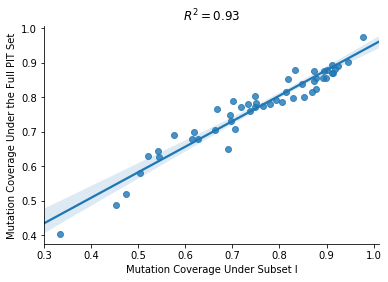

In [15]:
inc_num = 1 
incsubset_info(subset[:inc_num], 'Subset {}'.format('I' * inc_num), 'full_cov',
               utils.pit_results_path + '/inc-{}-results.ndjson'.format(inc_num))

In [ ]:
def concat_incsubset_data(subsetlist):
    prev = None
    for i in range(1, len(subsetlist) + 1):
        subset_data = utils.get_data_for_subset(mutators, subset=subsetlist[:i], submissions=submissions)
        subset_data = subset_data[['cov', 'mpl']]
        subset_data['mpl'] = subset_data['mpl']
        subset_data['subset'] = 'Subset {}'.format('I' * i)
        if prev is None:
            prev = subset_data
        else:
            prev = pd.concat([prev, subset_data])
    return prev

In [ ]:
# Prepare scatterplots
mpl = utils.factorisedsubsets(df=joined, dv='mpl')
cov = utils.factorisedsubsets(df=joined, dv='cov')
rt = utils.factorisedsubsets(df=joined, dv='runningtime')
df = mpl.reset_index() \
        .merge(right=cov.reset_index(), on=['userName', 'subset'],
               right_index=True, left_index=True)

# change this line to filter in/out specific "main subsets"
df = df[df['subset'].isin(['Deletion', 'Sufficient', 'Full'])]

# change this line to toggle the subsets found by forward selection  
# df = pd.concat([df, concat_incsubset_data(subset)], sort=False)

# subsets have the same colours/markers across scatterplots
cp = sns.color_palette()
subset_palette = {'Deletion': cp[0],
                  'Sufficient': cp[1],
                  'Full': cp[2],
                  'Subset I': cp[3],
                  'Subset II': cp[4],
                  'Subset III': cp[8]
}
subset_markers = {'Deletion': 'o',
                  'Sufficient': 'X',
                  'Full': 's',
                  'Subset I': 'P',
                  'Subset II': 'D',
                  'Subset III': '^' 
}

df['subset'] = pd.Categorical(df['subset'], ['Deletion', 
#                                              'Subset I',
                                             'Sufficient',
#                                              'Subset II',
                                             'Full',])
#                                              'Subset III'])

df['mpl'] = df['mpl'] * 1000
ax = sns.scatterplot(x='mpl', y='cov', style='subset', s=50, hue='subset', 
                     data=df, markers=subset_markers, palette=subset_palette)
ax.set(xlabel='# Mutants per KSLoC', ylabel='Mutation Coverage')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], loc='lower center', ncol=4, bbox_to_anchor=(0.5, 1))
sns.despine()
plt.tight_layout()
ax.get_figure().savefig('/home/ayaankazerouni/Desktop/main-subsets.eps')